#**W2D1 Tutorial 3: Multi-model ensembles**

> Indented block

> Indented block




**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson (Day Lead), Julius Busecke (Tutorial co-lead), Tom Nicholas (Tutorial co-lead)

**Content reviewers:** Jenna Pearson, Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

Today's tutorials demonstrate how to work with data from *Earth System Models* (ESMs) simulations conducted for the recent *Climate Model Intercomparison Project* (CMIP6) 

By the end of today's tutorials you will be able to:

*   Manipulate raw data from multiple CMIP6 models
*   Evaluate the spread of future projections from several CMIP6 models
*   Synthesize climate data from observations and models



#**Setup**

    



In [1]:
#Imports

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [1]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}


In [3]:
# @title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )



In [4]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

## **Tutorial 3: Multi-model ensembles**

In the previous section, you compared how a single CMIP6 model simulated past temperature, and how it projected temperature would change under a low-emissions scenario and a high-emissions scenario. 

Now we will start to compare data from multiple CMIP6 models. For this comparison, we will focus on just the historical simulation and the low-emissions projection (for now).

Complete the following code to plot 1850-2100 timeseries of global mean sea surface temperature for the 5 CMIP6 models that were loaded earlier (using the low-emissions future projection). 

In [5]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

##**Section 3.1: Load CMIP6 SST data again adn recreate the plot from Tutorial 2**



In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']

## **If the following cell crashes, run the cell a second time**

In [9]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [10]:
cat_area = col.search(
    source_id=source_ids,
    variable_id='areacello', # for the coding exercise, ellipses will go after the equals on this line
    member_id='r1i1p1f1',
    table_id='Ofx', # for the coding exercise, ellipses will go after the equals on this line
    grid_label='gn',
    experiment_id = ['historical'], # for the coding exercise, ellipses will go after the equals on this line
    require_all_on = ['source_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_area.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_area = cat_area.to_datatree(**kwargs)

dt_with_area = DataTree()

for model,subtree in dt.items():
    metric = dt_area[model]['historical'].ds['areacello']
    dt_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


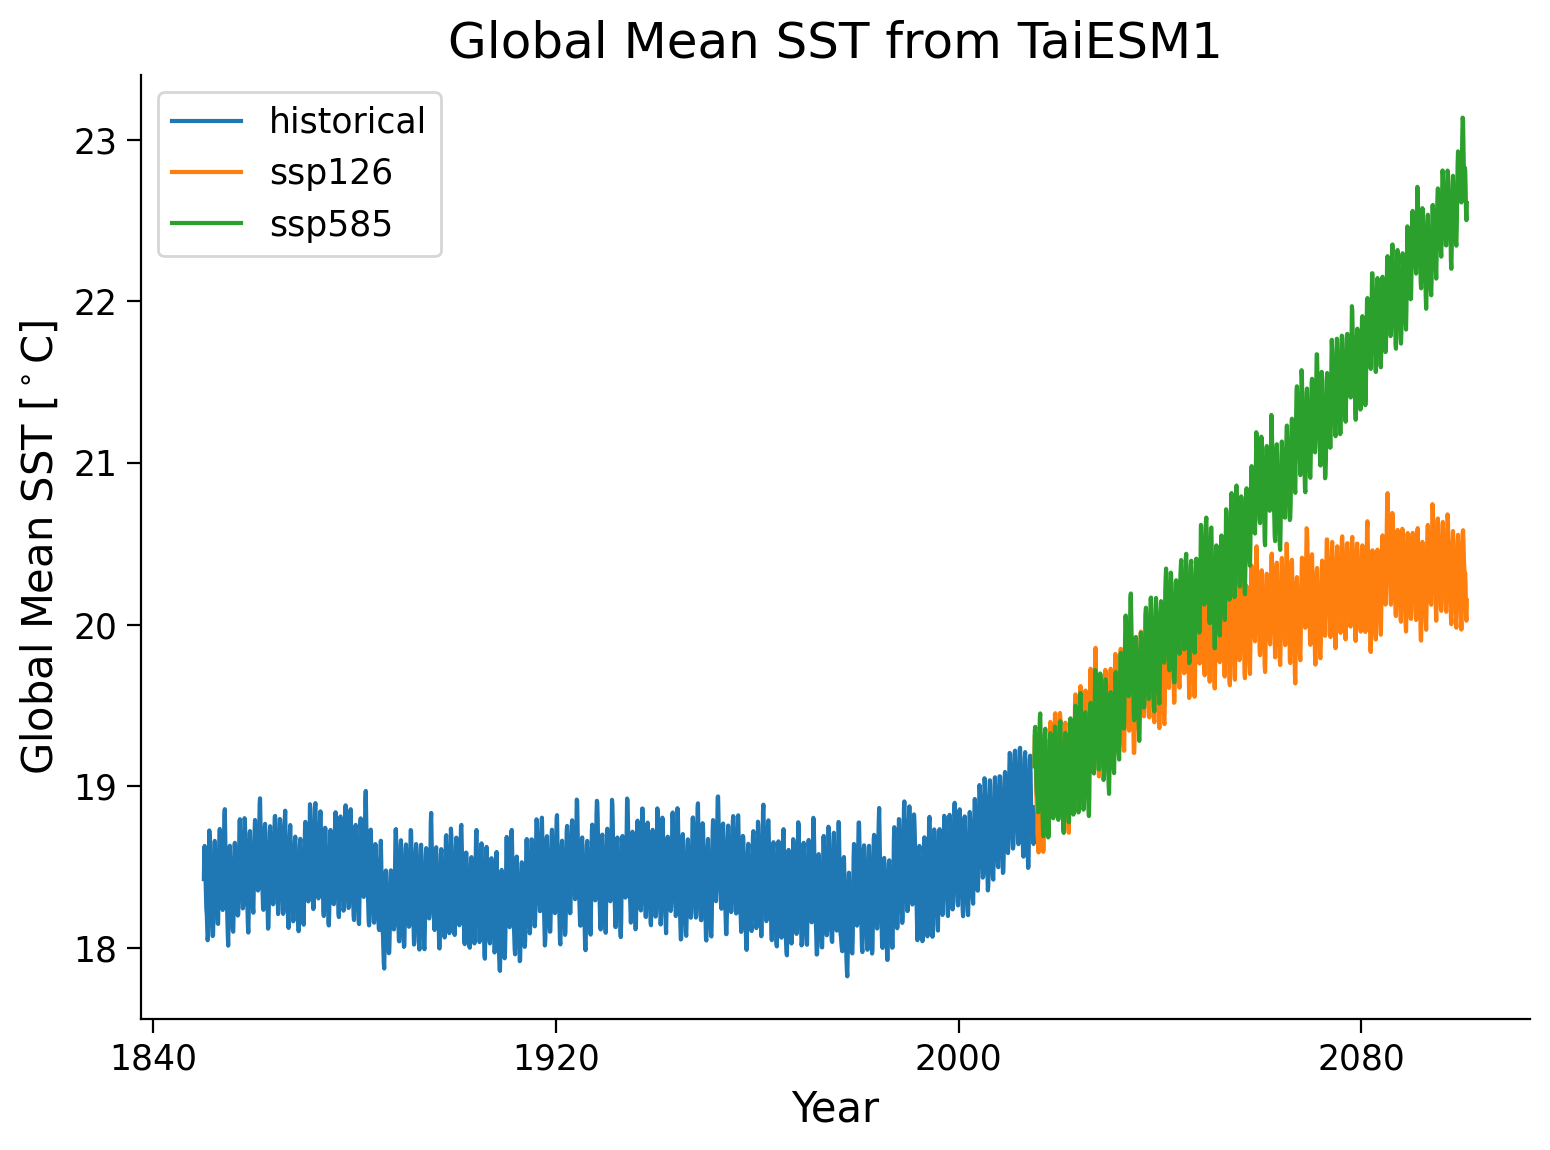

In [11]:
%matplotlib inline

# average every dataset in the tree globally
dt_gm = dt_with_area.map_over_subtree(global_mean)

for experiment in ['historical', 'ssp126', 'ssp585']:
    da = dt_gm['TaiESM1'][experiment].ds.tos
    da.plot(label=experiment)
plt.title('Global Mean SST from TaiESM1')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

plt.show()

###**Coding Exercise 3.1: Combine the past data and future data, and remove seasonal oscillations**

* The historical and projected data are separate time series. Can you complete the *xr.concat* function to combine the historical and projected data into a single continuous time series for each model?
* The previous timeseries oscillated very rapidly due to Earth's seasonal cycles. Can you complete the *xarray* *coarsen* function so that it smooths the monthly data with a one-year running mean? This will make it easier to distinguish the medium- to long-term changes in sea surface temperature

In [12]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Combine historical & future (ssp126) data from the same model and smooth with a 1-year running mean")
#################################################

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        # For each of the models, concatenate its historical and future data
        da_combined = xr.concat(...)
        # plot annual averages
        da_combined.coarsen(...).mean().plot(label=model) 
    
plot_historical_ssp126_combined(dt_gm)

plt.title('Global Mean SST from five CMIP6 models (annually smoothed)')
plt.ylabel('Global Mean SST [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

NotImplementedError: ignored

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

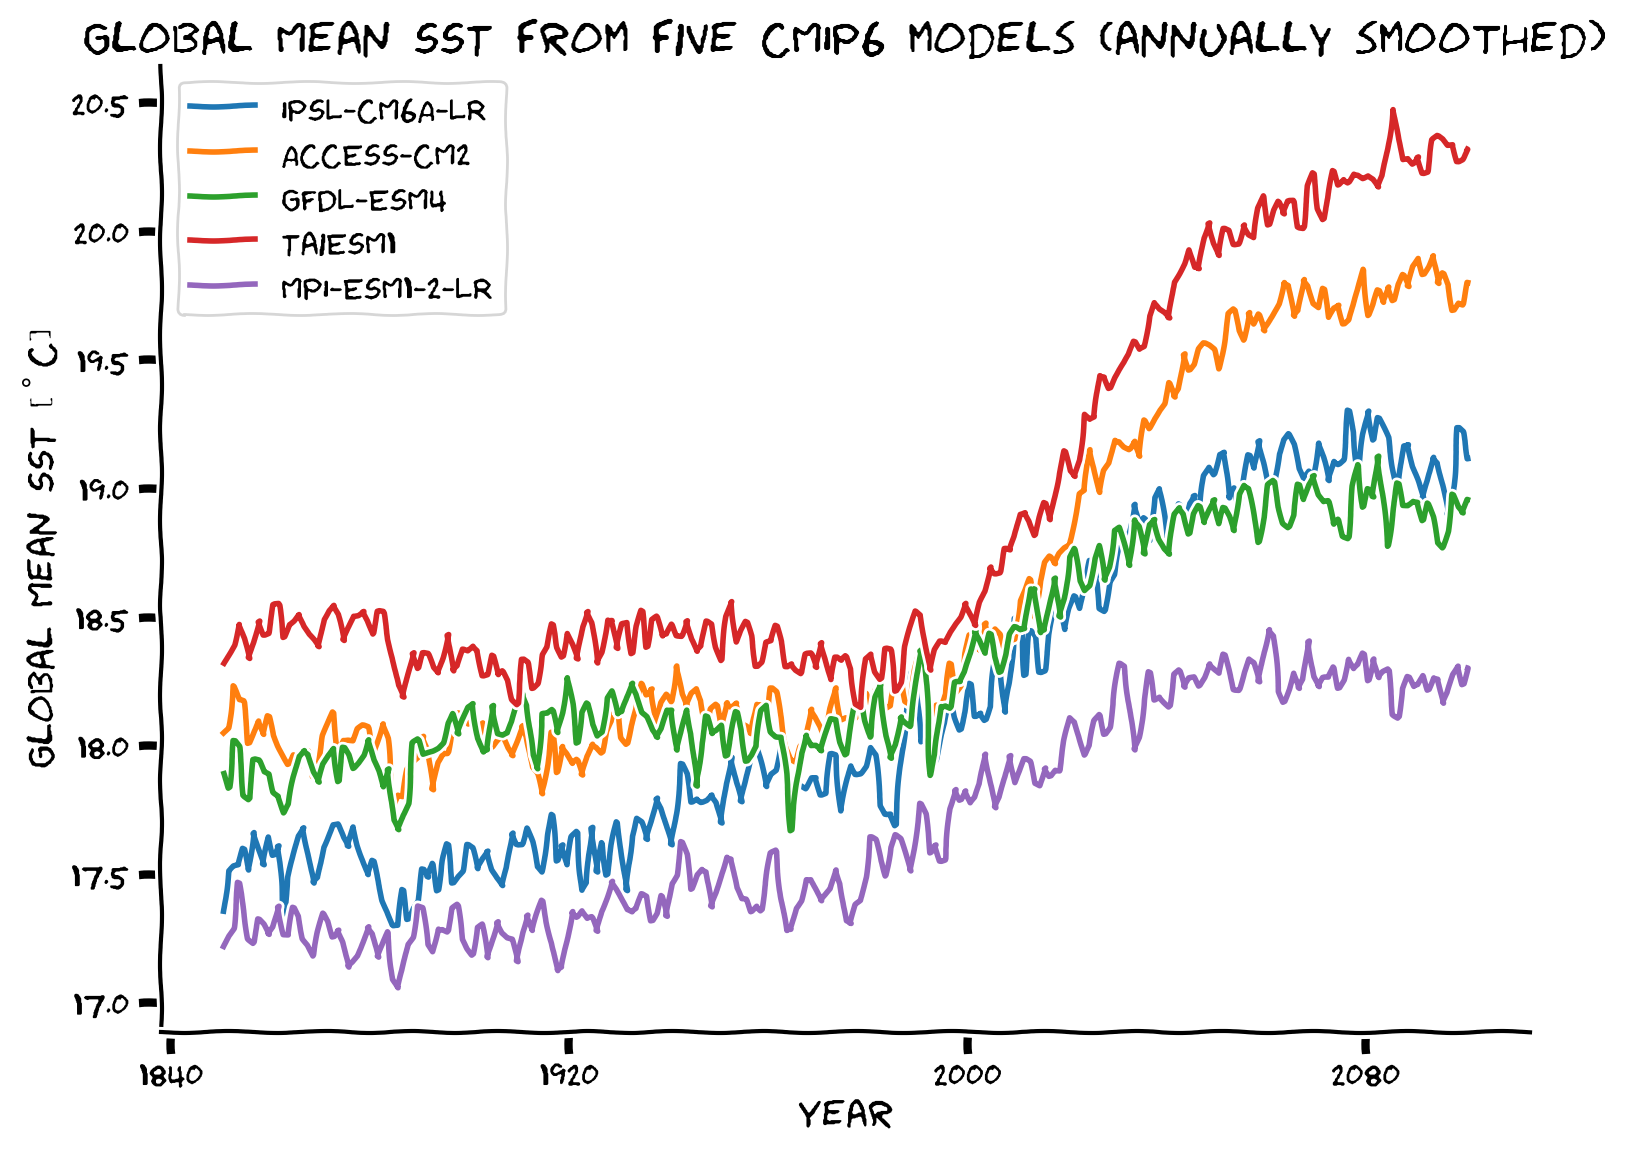

In [14]:
# to_remove solution

def plot_historical_ssp126_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        # For each of the models, concatenate its historical and future data
        da_combined = xr.concat(datasets, dim='time')
        # plot annual averages
        da_combined.coarsen(time=12).mean().plot(label=model) 

with plt.xkcd():    
  plot_historical_ssp126_combined(dt_gm)

  plt.title('Global Mean SST from five CMIP6 models (annually smoothed)')
  plt.ylabel('Global Mean SST [$^\circ$C]')
  plt.xlabel('Year')
  plt.legend()

## Post-figure questions

1.   Does anything about this plot surprise you?
2.   Why do you think the global mean temperature varies so much between models?* 

*If you get stuck here, use the lectures from earlier today and from the Climate Modelling day for inspiration

###**Coding Exercise 3.2: Calculate the temperature *anomaly***

As you just saw, the global mean temperature varies between climate models. This is not surprising given the slight differences in physics, numerics, and discretization between each model.

When we are looking at future projections, we care about how the model's *change* relative to their equilibrium/previous state. To do this, we typically subtract a historical reference period from the timeseries, which create a new timeseries of the temperature *anomaly* relative to that period.

**Modify the following code to recreate the previous multi-model figure, but now instead plot the global mean sea surface temperature (GMSST) *anomaly* relative the 1950-1980 period (i.e., subtract the 1950-1980 mean GMSST of each model from that model's timeseries)**

In [15]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Adapt the previous figure to plot the anomaly of global mean sea surface temperature relative to the 1950-1980 period")
#################################################

# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # Find the temporal average over the desired referene period
        ref = ...
        dt_out[model] = subtree - ref
    return dt_out

dt_gm_anomaly = datatree_anomaly(dt_gm)

plot_historical_ssp126_combined(dt_gm_anomaly)

plt.title('Global Mean SST Anomaly from five CMIP6 models (base period: 1950 to 1980)')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

NotImplementedError: ignored

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

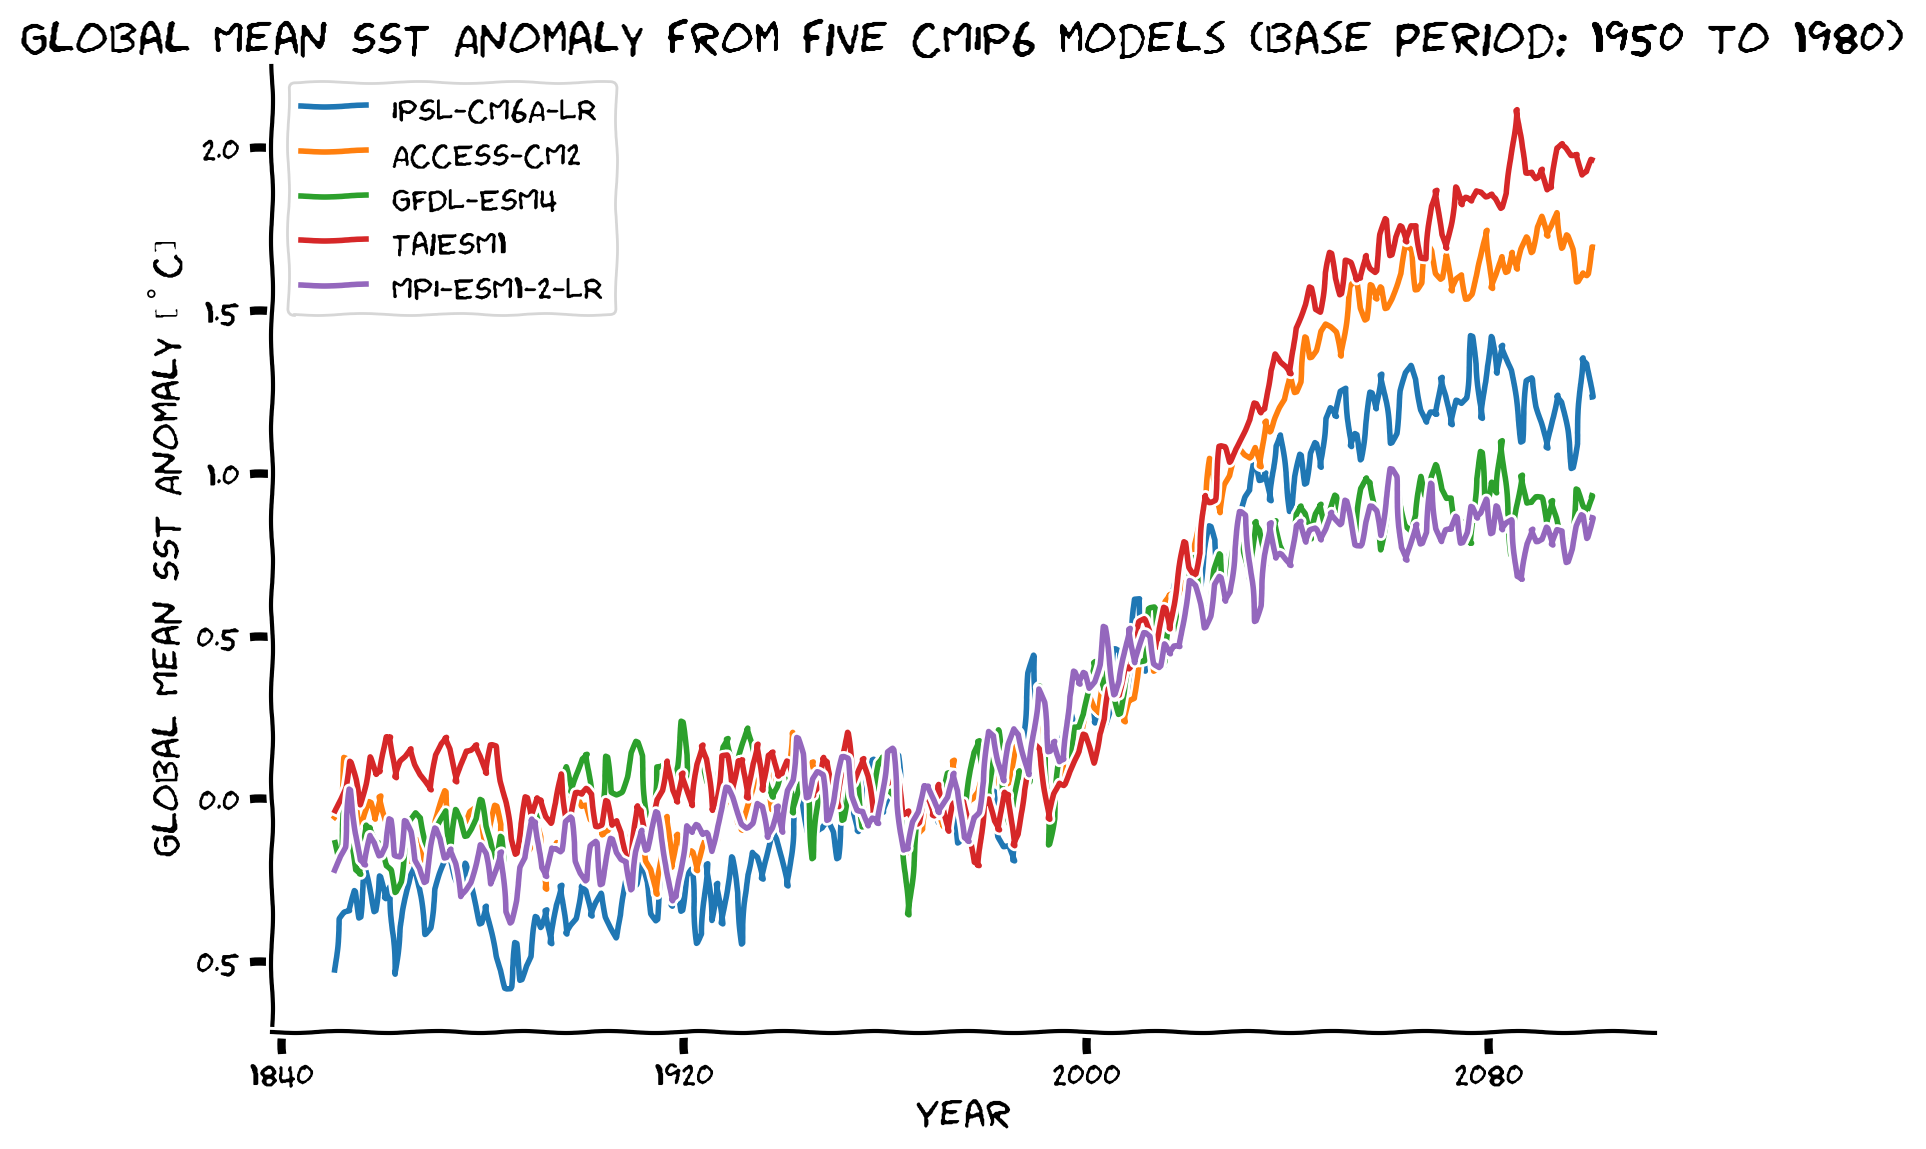

In [16]:
# to_remove solution

# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # Find the temporal average over the desired referene period
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out

dt_gm_anomaly = datatree_anomaly(dt_gm)

with plt.xkcd(): 
  plot_historical_ssp126_combined(dt_gm_anomaly)

  plt.title('Global Mean SST Anomaly from five CMIP6 models (base period: 1950 to 1980)')
  plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
  plt.xlabel('Year')
  plt.legend()

## Post-figure question

1.   How does this figure compare to the previous one where the reference period was not subtracted?
